# Final Project
##### Game theory and Networked Systems

In the 1980s, professor of Political Science Robert Axelrod ran a tournament inviting strategies from collaborators all over the world for the Iterated Prisoner’s Dilemma.

In [2]:
import itertools
import random
import matplotlib.pyplot as plt
import axelrod as axl

### Axelrod's First Tournament

[related document](https://axelrod.readthedocs.io/en/latest/tutorials/running_axelrods_first_tournament/index.html)

In [4]:

first_tournament_participants_ordered_by_reported_rank = [s() for s in axl.axelrod_first_strategies]
number_of_strategies = len(first_tournament_participants_ordered_by_reported_rank)

**reference**: Axelrod, R. (1980). Effective Choice in the Prisoner’s Dilemma. Journal of Conflict Resolution, 24(1), 3–25.

Analysing: 100%|██████████| 25/25 [00:00<00:00, 210.97it/s]


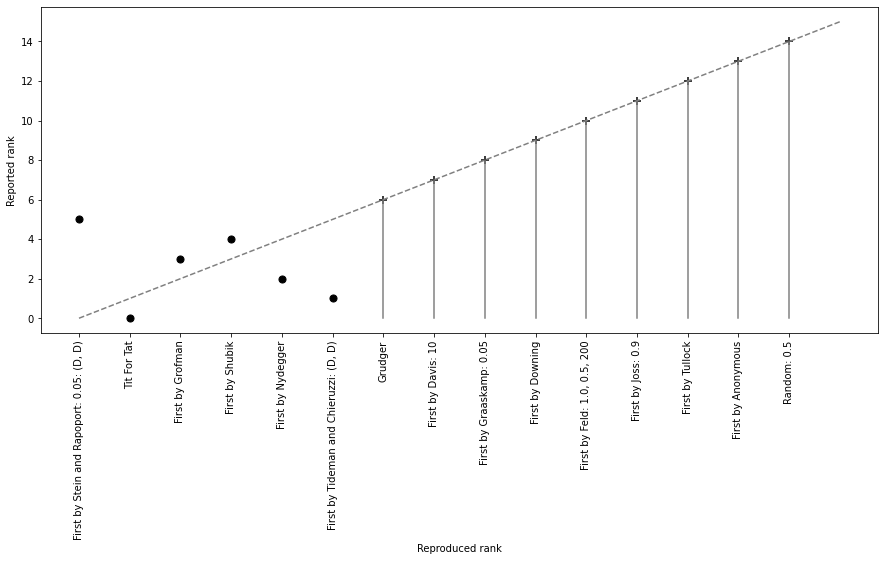

In [4]:
tournament = axl.Tournament(
     # players=[axl.Defector(), axl.Defector(), axl.Defector(),
     #   axl.Defector(), axl.Defector(), axl.Defector(),
     #    axl.Defector(), axl.Defector(), axl.Defector(),
     #    axl.Defector(), axl.Defector(), axl.Defector(),
     #    axl.TitForTat(),axl.TitForTat(),
     #   axl.Defector(), axl.Defector(), axl.Defector()],
     players=first_tournament_participants_ordered_by_reported_rank,
     turns=200,
     repetitions=5,
     seed=2,
)

results = tournament.play()
plt.figure(figsize=(15, 6))
plt.plot((0, 15), (0, 15), color="grey", linestyle="--")
for original_rank, strategy in enumerate(first_tournament_participants_ordered_by_reported_rank):
    rank = results.ranked_names.index(str(strategy))
    if rank == original_rank:
        symbol = "+"
        plt.plot((rank, rank), (rank, 0), color="grey")
    else:
        symbol = "o"
    plt.scatter([rank], [original_rank], marker=symbol, color="black", s=50)


plt.xticks(
    range(number_of_strategies),
    results.ranked_names,
    rotation=90
)
plt.ylabel("Reported rank")
plt.xlabel("Reproduced rank")
plt.show()


We can plot the reported rank (from [Axelrod1980]) versus the reproduced one:

C:\Users\gjq\AppData\Local\Temp\ipykernel_21632\2809675426.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


<Figure size 2000x800 with 0 Axes>

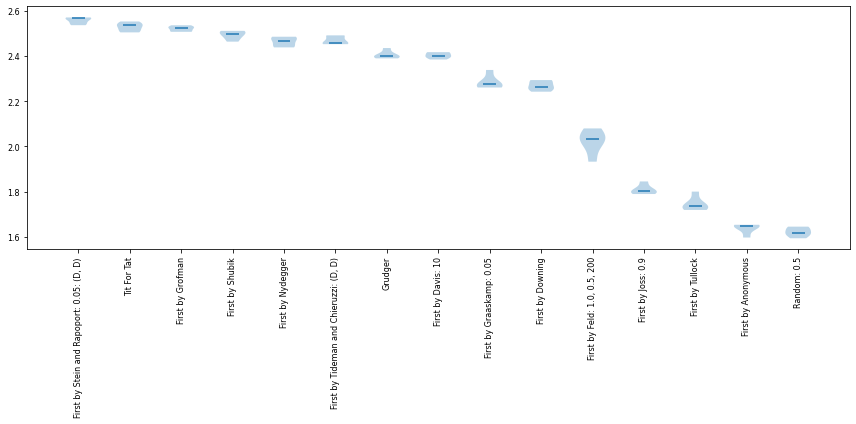

In [5]:
plt.figure(figsize=(5,2),dpi=400)
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

The first 6 strategies have similar scores which could indicate that the original work by Axelrod was not run with sufficient repetitions. Another explanation is that all the strategies are implemented from the descriptions given in [Axelrod1980] and there is no source code to base this on. This leads to some strategies being ambiguous.

In [6]:
# To print out the strategy docstrings:
print(axl.random.__doc__)

AttributeError: module 'axelrod' has no attribute 'random'

### Moran Proccesses

The Moran process is a common population model of natural selection. The basic idea of the model is that we have a population of individuals. The population size is fixed throughout. Each round every player interacts with every other player, in this case the default game in the axelrod library, the prisoner’s dilemma.

The strategies in the library can be pitted against one another in the Moran process, a population process simulating natural selection.

The process works as follows. Given an initial population of players, the population is iterated in rounds consisting of:

    1. matches played between each pair of players, with the cumulative total scores recorded
    2. a player is chosen to reproduce proportional to the player’s score in the round
    3. a player is chosen at random to be replaced
The process proceeds in rounds until the population consists of a single player type. That type is declared the winner. To run an instance of the process with the library, proceed as follows:

Let's create a population of players and run the population dynamic.

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)
players = [axl.Defector(), axl.Defector(), axl.Defector(),
       axl.Cooperator(), axl.Cooperator(), axl.Cooperator(),
           # axl.Grudger(),axl.Grudger(),axl.Grudger(),
       axl.TitForTat(), axl.TitForTat(), axl.TitForTat(),
       axl.Random()]
mp = axl.MoranProcess(players=players, turns=200, seed=3)
populations = mp.play()
print("The winner is:", mp.winning_strategy_name)

The winner is: Defector


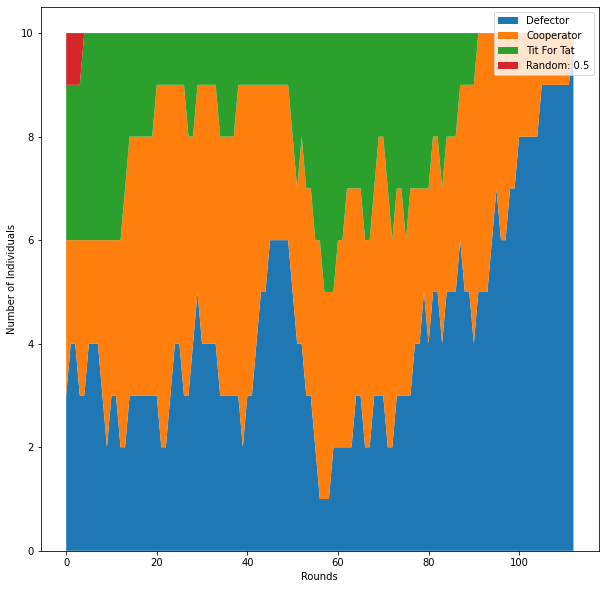

In [8]:
# Plot the results

player_names = mp.populations[0].keys()

plot_data = []
labels = []
for name in player_names:
    labels.append(name)
    values = [counter[name] for counter in mp.populations]
    plot_data.append(values)
    domain = range(len(values))

plt.stackplot(domain, plot_data, labels=labels)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Number of Individuals")
plt.show()

It is possible to pass a fitness function that scales the utility values. A common one used in the literature, [Ohtsuki2006], is f(s)=1−w+ws where w denotes the intensity of selection:

reference: Ohtsuki, Hisashi, et al. “A simple rule for the evolution of cooperation on graphs and social networks.” Nature 441.7092 (2006): 502.

In [69]:
players = (axl.Cooperator(), axl.Defector(), axl.Defector(), axl.Defector())
w = 0.95
fitness_transformation = lambda score: 1 - w + w * score
mp = axl.MoranProcess(players, turns=10, fitness_transformation=fitness_transformation, seed=3)
populations = mp.play()
mp.winning_strategy_name

'Defector'

### With Mutation

We can also run a population with mutation. It will never converge so we need to limit the number of rounds.

In [62]:
# Create a population of size 30
N = 25
players = []
for _ in range(N):
    player = random.choice([axl.TitForTat, axl.Cooperator, axl.Defector])
    players.append(player())

rounds = 1000
mp = axl.MoranProcess(players=players, turns=200, mutation_rate=0.05)
list(itertools.islice(mp, rounds))
print("Completed {} rounds.".format(rounds))

Completed 1000 rounds.


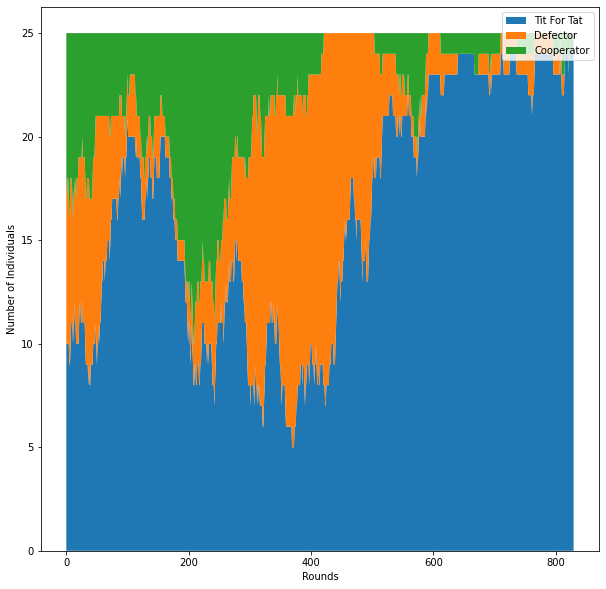

In [68]:
# Plot the results

player_names = mp.populations[0].keys()

plot_data = []
labels = []
for name in player_names:
    labels.append(name)
    values = [counter[name] for counter in mp.populations]
    plot_data.append(values)
    domain = range(len(values))

plt.stackplot(domain, plot_data, labels=labels)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Number of Individuals")
plt.show()

### Ecological Variant
In Axelrod’s original work an ecological approach based on the payoff matrix of the tournament was used to study the evolutionary stability of each strategy. Whilst this bears some comparison to the Moran Process, the latter is much more widely used in the literature.

To study the evolutionary stability of each strategy it is possible to create an ecosystem based on the payoff matrix of a tournament:

In [1]:
import axelrod as axl
players = [axl.Cooperator(), axl.Defector(),
           axl.TitForTat(), axl.Grudger(),
           axl.Grudger(),axl.Grudger(),
           axl.Random()]
tournament = axl.Tournament(players)
results = tournament.play()
eco = axl.Ecosystem(results)
eco.reproduce(100)

Analysing: 100%|██████████| 25/25 [00:00<00:00, 370.36it/s]


C:\Users\gjq\AppData\Local\Temp\ipykernel_7712\2948113678.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


<Figure size 1000x1000 with 0 Axes>

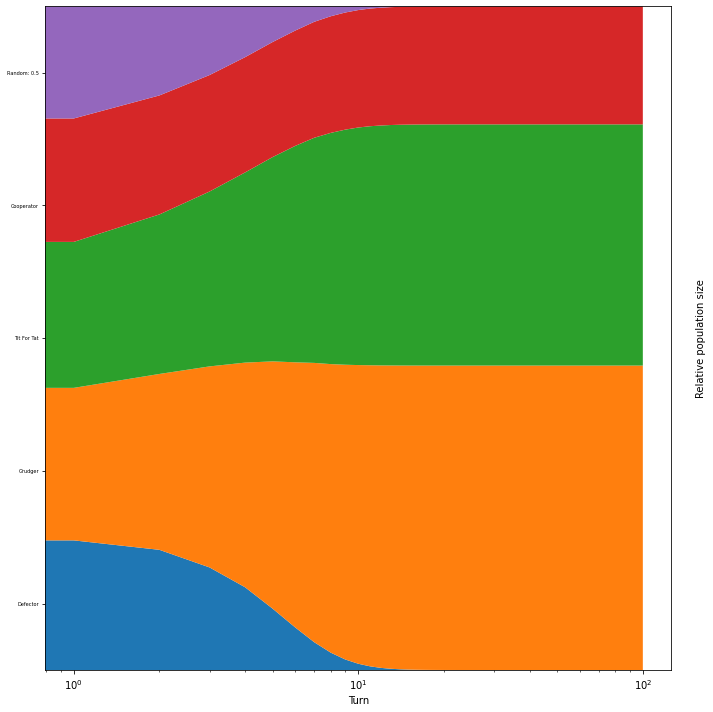

In [21]:
plt.figure(figsize=(5,5),dpi=200)
plot = axl.Plot(results)
p = plot.stackplot(eco)
p.show()

### Fingerprint
In [Ashlock2008], [Ashlock2009] a methodology for obtaining visual representation of a strategy’s behaviour is described. The basic method is to play the strategy against a probe strategy with varying noise parameters. These noise parameters are implemented through the JossAnnTransformer. The Joss-Ann of a strategy is a new strategy which has a probability x of cooperating, a probability y of defecting, and otherwise uses the response appropriate to the original strategy. We can then plot the expected score of the strategy against x and y and obtain a heat plot over the unit square. When x + y >= 1 the JossAnn is created with parameters (1-y, 1-x) and plays against the Dual of the probe instead.

reference: Ashlock, D., & Kim, E. Y. (2008). Fingerprinting: Visualization and automatic analysis of prisoner’s dilemma strategies. IEEE Transactions on Evolutionary Computation, 12(5), 647–659. http://doi.org/10.1109/TEVC.2008.920675

Ashlock, D., Kim, E. Y., & Ashlock, W. (2009) Fingerprint analysis of the noisy prisoner’s dilemma using a finite-state representation. IEEE Transactions on Computational Intelligence and AI in Games. 1(2), 154-167 http://doi.org/10.1109/TCIAIG.2009.2018704

100%|██████████| 72/72 [00:00<00:00, 2769.20it/s]
C:\Users\gjq\AppData\Local\Temp\ipykernel_7712\2812686866.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


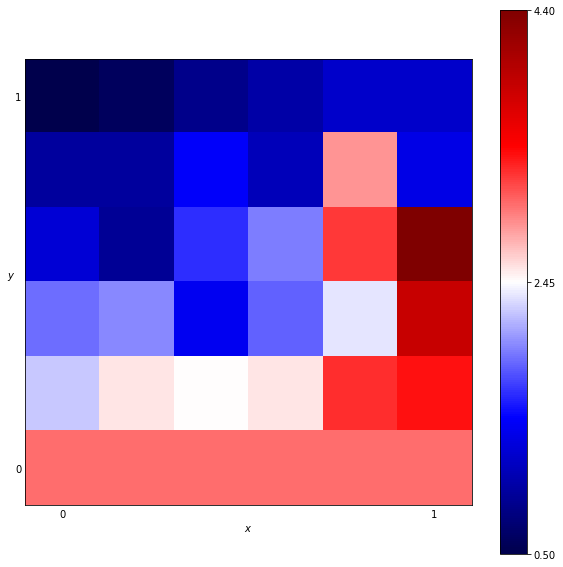

In [24]:
strategy = axl.WinStayLoseShift
probe = axl.TitForTat
af = axl.AshlockFingerprint(strategy, probe)
data = af.fingerprint(turns=10, repetitions=2, step=0.2, seed=1)
p = af.plot()
p.show()

The fingerprint method returns a dictionary mapping coordinates of the form (x, y) to the mean score for the corresponding interactions. We can then plot the above to get:

### Transitive Fingerprint
Another implemented fingerprint is the transitive fingerprint. The transitive fingerprint represents the cooperation rate of a strategy against a set of opponents over a number of turns.

By default the set of opponents consists of 50 Random players that cooperate with increasing probability. This is how to obtain the transitive fingerprint for TitForTat:

In [25]:
player = axl.TitForTat()
tf = axl.TransitiveFingerprint(player)
data = tf.fingerprint(turns=40, seed=3)

Playing matches: 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


C:\Users\gjq\AppData\Local\Temp\ipykernel_7712\4046627012.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


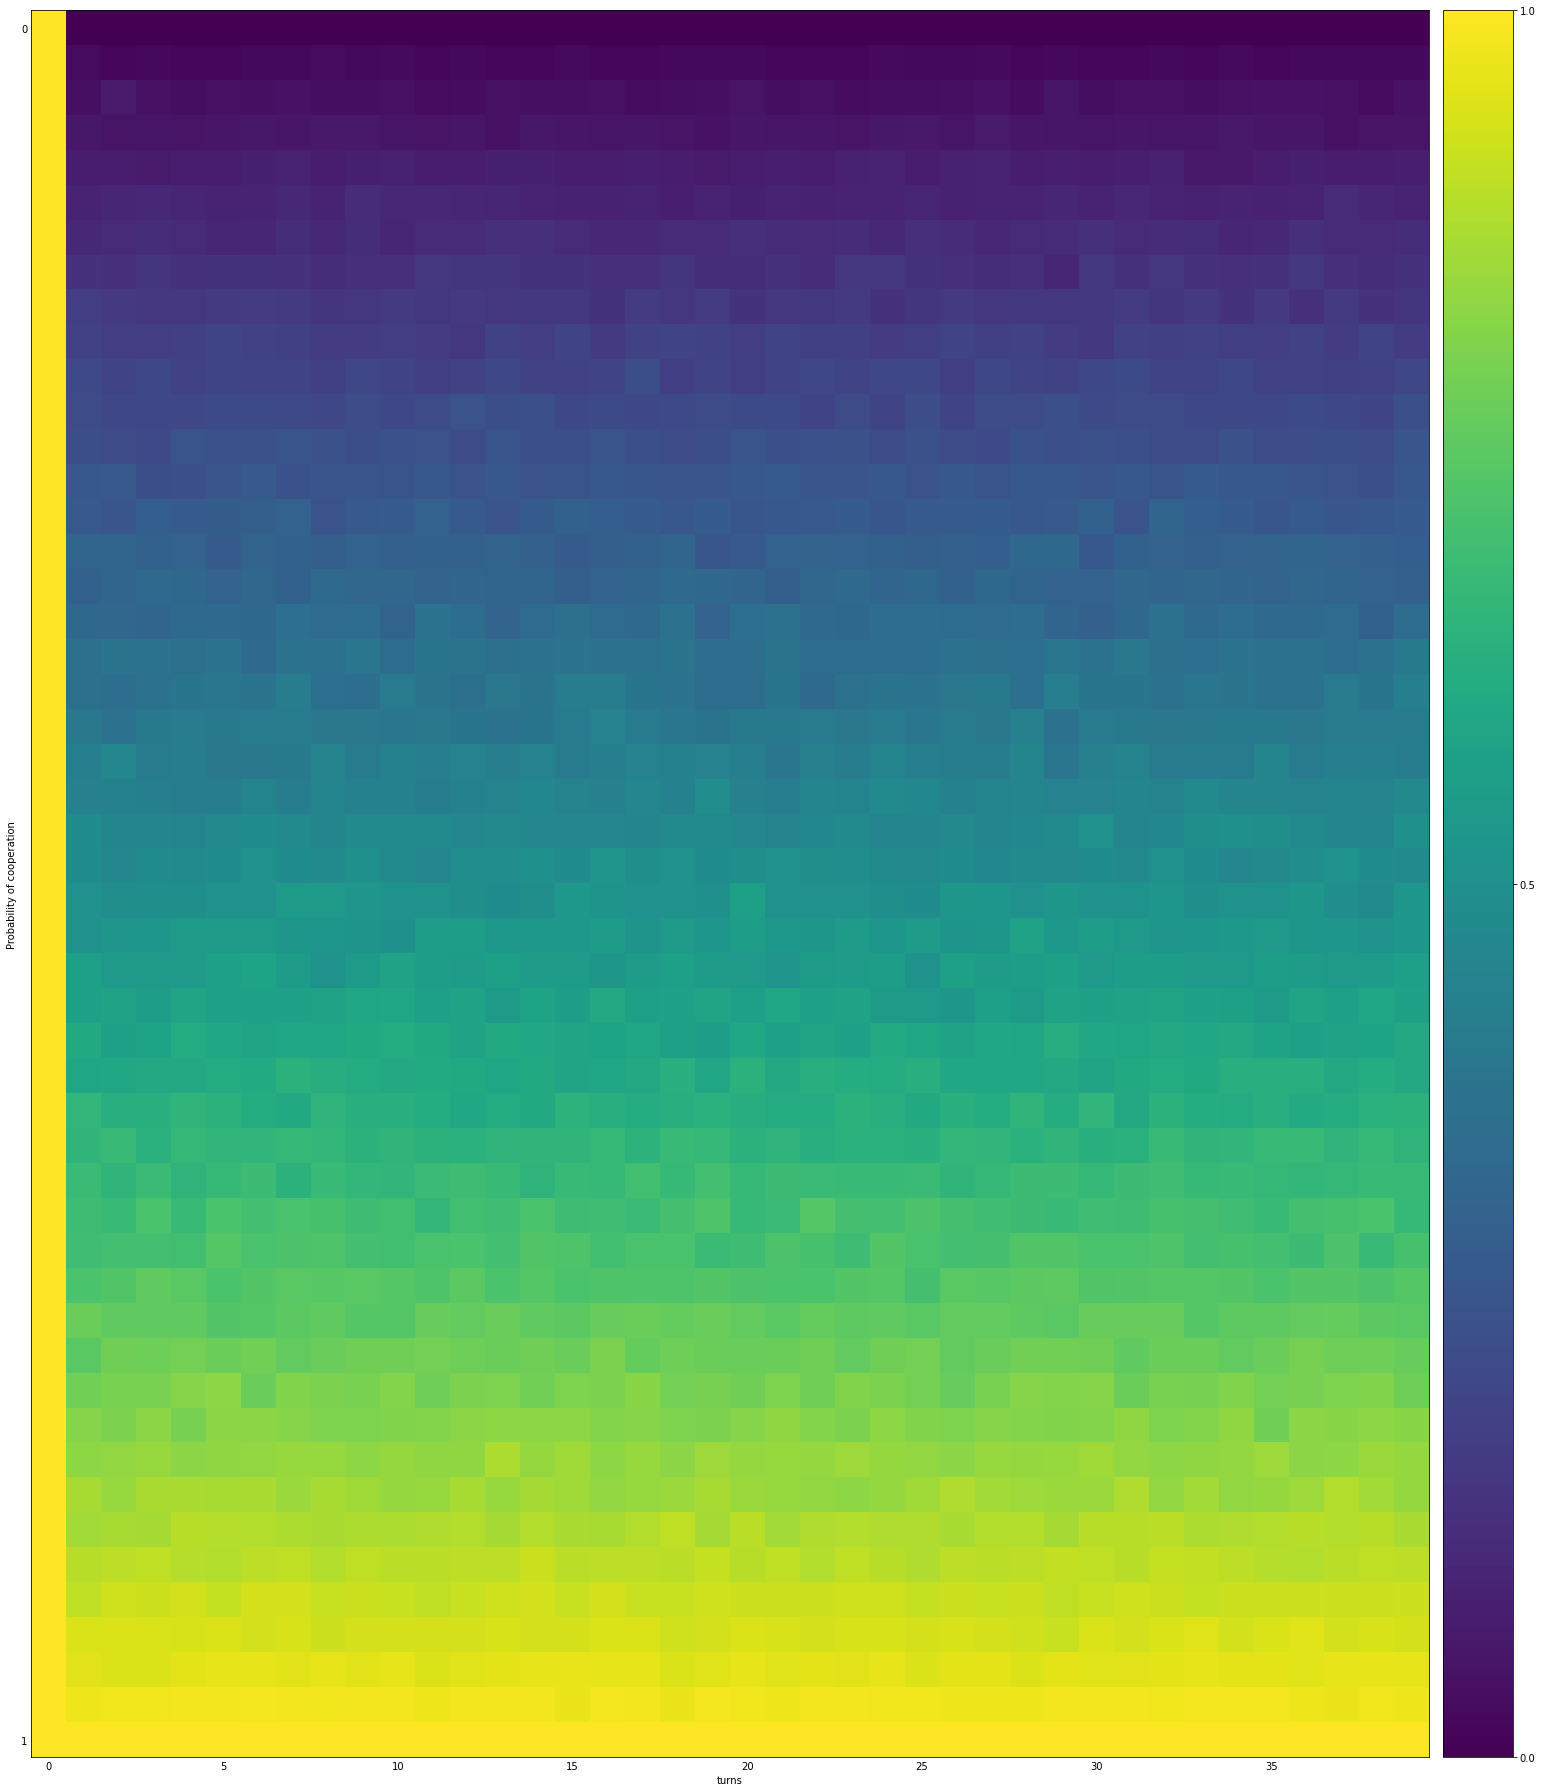

In [27]:
p = tf.plot()
p.show()

It is also possible to fingerprint against a given set of opponents:

In [46]:
opponents = [s() for s in axl.demo_strategies]
tf = axl.TransitiveFingerprint(player, opponents=opponents)
data = tf.fingerprint(turns=5, repetitions=10, seed=4)

Playing matches: 100%|██████████| 5/5 [00:00<00:00, 1250.24it/s]


C:\Users\gjq\AppData\Local\Temp\ipykernel_7712\1085607456.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p1.show()


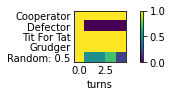

In [47]:
p1 = tf.plot(display_names=True)
p1.show()

### Visualising results

As shown in Creating and running a simple tournament, let us create a tournament, but this time we will include a player that acts randomly:

Analysing: 100%|██████████| 25/25 [00:00<00:00, 416.66it/s]
C:\Users\gjq\AppData\Local\Temp\ipykernel_7712\3900050182.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


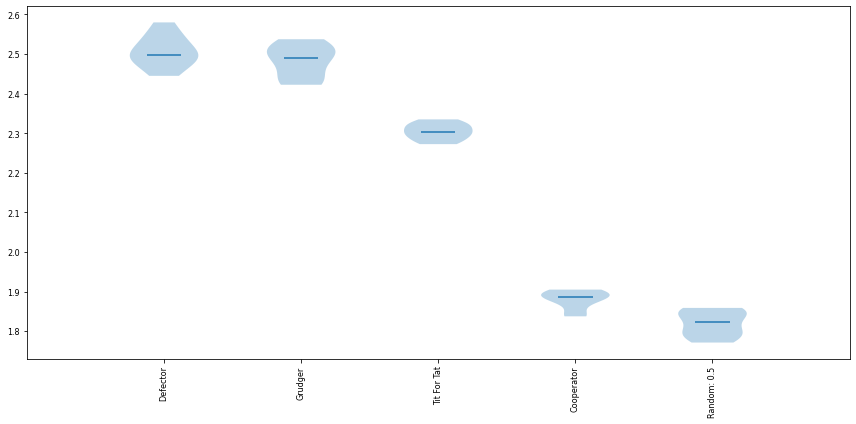

In [65]:
import axelrod as axl
players = [axl.Cooperator(), axl.Defector(),
           axl.TitForTat(), axl.Grudger()]
players.append(axl.Random())
tournament = axl.Tournament(players)
results = tournament.play()

plot = axl.Plot(results)
p = plot.boxplot()
p.show()

### Visualising the payoff matrix
We can also easily view the payoff matrix described in Access tournament results, this becomes particularly useful when viewing the outputs of tournaments with a large number of strategies:

C:\Users\gjq\AppData\Local\Temp\ipykernel_7712\2170753637.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


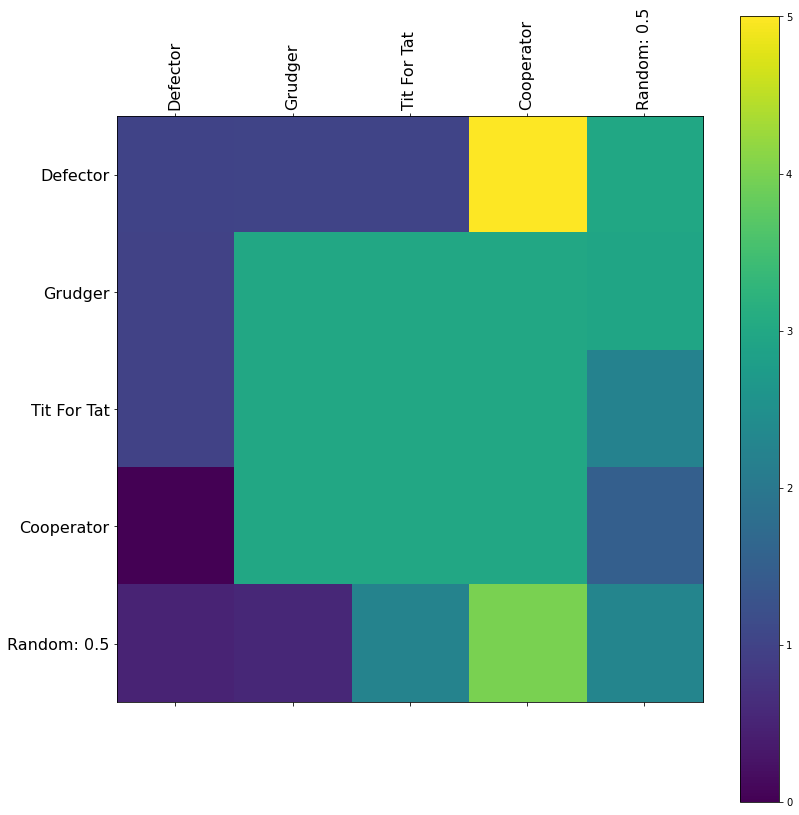

In [66]:
p = plot.payoff()
p.show()

Alwayer defector world

The winner is: Tit For Tat


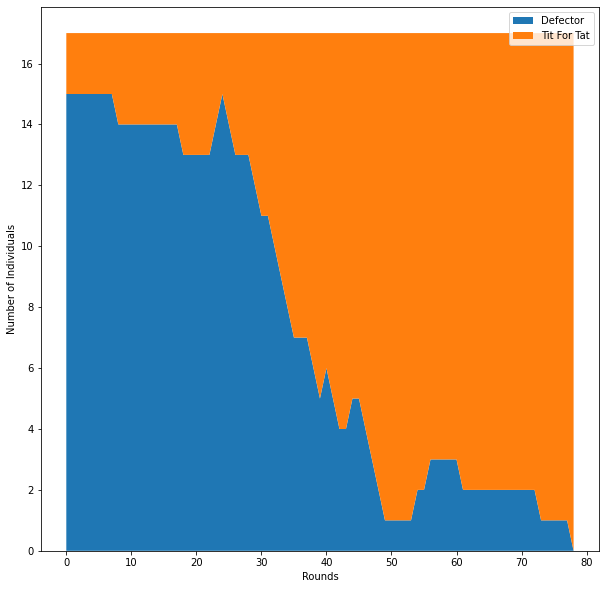

In [72]:
plt.rcParams['figure.figsize'] = (10, 10)
players = [axl.Defector(), axl.Defector(), axl.Defector(),
       axl.Defector(), axl.Defector(), axl.Defector(),
        axl.Defector(), axl.Defector(), axl.Defector(),
        axl.Defector(), axl.Defector(), axl.Defector(),
           axl.TitForTat(),axl.TitForTat(),
       axl.Defector(), axl.Defector(), axl.Defector()
           ]
mp = axl.MoranProcess(players=players, turns=200, seed=2)
populations = mp.play()
print("The winner is:", mp.winning_strategy_name)
# Plot the results

player_names = mp.populations[0].keys()

plot_data = []
labels = []
for name in player_names:
    labels.append(name)
    values = [counter[name] for counter in mp.populations]
    plot_data.append(values)
    domain = range(len(values))

plt.stackplot(domain, plot_data, labels=labels)
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Number of Individuals")
plt.show()